# Modelos mecanicistas para a hidrólise enzimática

As equações a seguir representam subreações da etapa de hidrólise enzimática de matéria prima lignocelulósica.

## Variáveis

In [23]:
params = {
    "alpha": 1,
    "Emax": 8.32,
    "Kad": 7.16,
    "k1r": 0.509,
    "k2r": 12.75,
    "k3r": 165.7,
    "k4r": 13.46,
    "K1iG": 0.016,
    "K1iG2": 0.710,
    "K1iX": 0.559,
    "K2iG": 89.18,
    "K2iG2": 0.551,
    "K2iX": 0.581,
    "K3M": 47.20,
    "K3iG": 0.011,
    "K3iX": 110.0,
    "K4iG": 30.16,
    "K4iG2": 8.61,
    "K4iX": 134.1
}

## Parâmetros ajustados

In [24]:
# Emax = 8.32
# Kad = 7.16
# alpha = 1
# k1r = 0.177
# k2r = 8.81
# k3r = 201.0
# k4r = 16.34
# K1iG = 0.402
# K1iG2 = 2.71
# K1iX = 2.15
# K2iG = 119.6
# K2iG2 = 4.69
# K2iX = 0.095
# K3M = 26.6
# K3iG = 11.06
# K3iX = 1.023
# K4iG = 16.25
# K4iG2 = 4.0
# K4iX = 154.0

## Equações

### Definições

In [25]:
#Langmuir-type isotherm 1

def Ebs1(Eb , S):

    Ebs1 = Eb/S

    return Ebs1

In [26]:
# Langmuir-type isotherm 2

def Ebs2(Emax, Kad, Ef):

    Ebs2 = Emax*Kad*Ef/(1+Kad*Ef)

    return Ebs2

In [27]:
# Eb = S*Emax*Ef/(1+Kad*Ef)
def Eb(S, Emax, Ef, Kad):

    Eb = S*Emax*Ef/(1+Kad*Ef)

    return Eb

In [28]:
# Enzyme adsorbed on cellulose

def Ebc(Eb, C, S):

    Ebc = Eb*C/S

    return Ebc

In [29]:
# Enzyme adsorbed on hemicellulose
def Ebh(Eb, H, S):

    Ebh = Eb*H/S

    return Ebh

In [30]:
# Substrate reactivity

def Rs(alpha, S, S0):

    Rs = alpha*S/S0

    return Rs

### Taxas de reação

In [31]:
# Reaction 1: Cellulose to cellobiose

def r1(k1r, Ebc, S, Rs, G2, G, X, K1iG, K1iG2, K1iX):

    r1 = k1r*Ebc*S*Rs/(1+ G2/K1iG2 + G/K1iG + X/K1iX)
    return r1

In [32]:
# Reaction 2: Cellulose to glucose
def r2(k2r, Ebc, S, Rs, G2, G, X, K2iG, K2iG2, K2iX):

    r2 = k2r*Ebc*S*Rs/(1+ G2/K2iG2 + G/K2iG + X/K2iX)
    return r2

In [33]:
# Reaction 3: Cellobiose to glucose
def r3(k3r, Ef, G2, G, X, K3M, K3iG, K3iX):

    r3 = k3r*Ef*G2/(((1 + G/K3iG + X/K3iX)*K3M)+G2)

    return r3

In [34]:
# Reaction 4: Hemicellulose to Xilose
def r4(k4r, Ebh, Rs, S, G2, G, X, K4iG, K4iG2, K4iX):

    r4 = k4r*Ebh*Rs*S/(1 + G2/K4iG2 + G/K4iG + X/K4iX)

    return r4

### Balanços de massa

In [35]:
# Total Enzyme
def Et(Eb, Ef):
    Et = Eb + Ef
    return Et

In [36]:
# Total Solids

def S(C, H, L):
    S = C + H + L
    return S

### Taxa de variação de componentes

In [37]:
# Cellulose balance

def dC_dt(r1, r2):

    dC_dt = -r1 - r2
    return dC_dt

In [38]:
# Cellobiose balance

def dG2_dt(r1, r3):
    dG2_dt = 1.056*r1 - r3
    return dG2_dt

In [39]:
# Glucose balance
def dG_dt(r2, r3):
    dG_dt = 1.111*r2 + 1.053*r3
    return dG_dt

In [40]:
# Hemicellulose balance

def dH_dt(r4):
    dH_dt = -r4
    return dH_dt

In [41]:
# Xylose balance
def dX_dt(r4):
    dX_dt = 1.136*r4
    return dX_dt

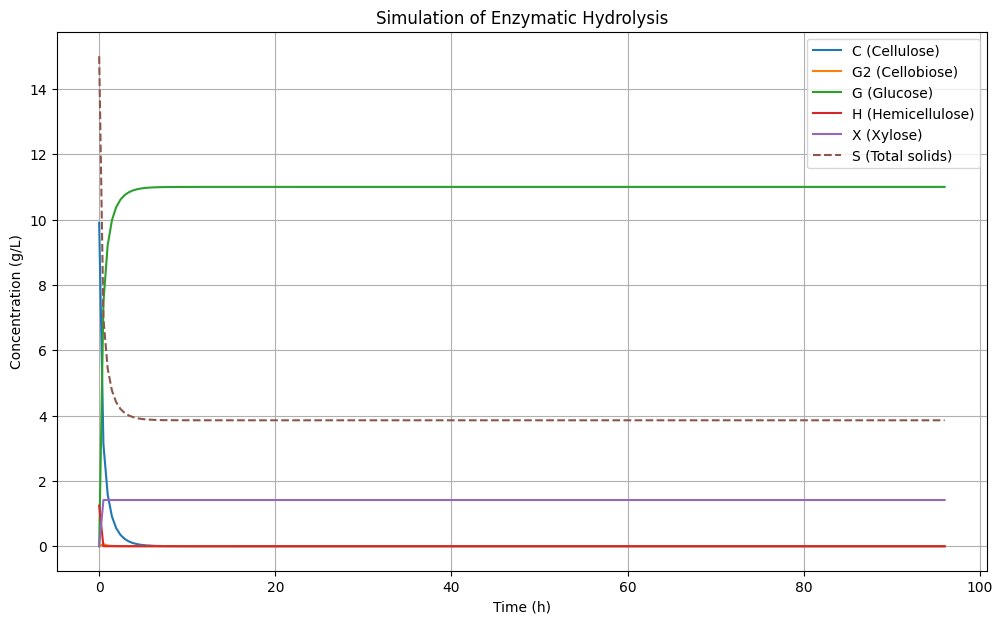

In [42]:
import numpy as np
from scipy.integrate import solve_ivp

# Defina a composição da biomassa e a carga de sólidos (exemplo)
biomass_composition = {
    'cellulose': 0.66,        # fração mássica de celulose
    'hemicellulose': 0.083,   # fração mássica de hemicelulose
    'lignin': 0.257           # fração mássica de lignina
}
solids_loading_g_L = 15  # concentração total de sólidos em g/L

# Calculando as concentrações iniciais
C0 = solids_loading_g_L * biomass_composition['cellulose']
H0 = solids_loading_g_L * biomass_composition['hemicellulose']
L0 = solids_loading_g_L * biomass_composition['lignin']

S0 = C0 + H0 + L0  # S0 calculado corretamente

# Defina Ef0 e Eb0
Ef0 = 10  # g/L
Eb0 = 0   # g/L

# Função que define o sistema de equações diferenciais
def hydrolysis_ode(t, y, params, S0=S0):
    C, G2, G, H, X, Eb, Ef = y  # Agora Eb e Ef são variáveis de estado

    # Parâmetros do dicionário (apenas os cinéticos)
    alpha = params["alpha"]
    Emax = params["Emax"]
    Kad = params["Kad"]
    k1r = params["k1r"]
    k2r = params["k2r"]
    k3r = params["k3r"]
    k4r = params["k4r"]
    K1iG = params["K1iG"]
    K1iG2 = params["K1iG2"]
    K1iX = params["K1iX"]
    K2iG = params["K2iG"]
    K2iG2 = params["K2iG2"]
    K2iX = params["K2iX"]
    K3M = params["K3M"]
    K3iG = params["K3iG"]
    K3iX = params["K3iX"]
    K4iG = params["K4iG"]
    K4iG2 = params["K4iG2"]
    K4iX = params["K4iX"]

    # Variáveis auxiliares
    S = C + H + L0
    Rs = alpha * S / S0
    Ebc = Eb * C / S if S > 0 else 0
    Ebh = Eb * H / S if S > 0 else 0

    # Taxas de reação
    r1 = k1r * Ebc * S * Rs / (1 + G2 / K1iG2 + G / K1iG + X / K1iX)
    r2 = k2r * Ebc * S * Rs / (1 + G2 / K2iG2 + G / K2iG + X / K2iX)
    r3 = k3r * Ef * G2 / (((1 + G / K3iG + X / K3iX) * K3M) + G2)
    r4 = k4r * Ebh * Rs * S / (1 + G2 / K4iG2 + G / K4iG + X / K4iX)

    # Adsorção/dessorção enzimática (Langmuir)
    taxa_ads = Kad * Ef * (Emax - Eb)
    taxa_dess = Kad * Eb
    dEb_dt = taxa_ads - taxa_dess
    dEf_dt = -dEb_dt

    # Equações diferenciais
    dC_dt = -r1 - r2
    dG2_dt = 1.056 * r1 - r3
    dG_dt = 1.111 * r2 + 1.053 * r3
    dH_dt = -r4
    dX_dt = 1.136 * r4

    return [dC_dt, dG2_dt, dG_dt, dH_dt, dX_dt, dEb_dt, dEf_dt]

# Parâmetros do modelo como dicionário (apenas os cinéticos)
params = {
    'alpha': 1,
    'Emax': 8.32,
    'Kad': 7.16,
    'k1r': 0.177,
    'k2r': 8.81,
    'k3r': 201.0,
    'k4r': 16.34,
    'K1iG2': 0.402,
    'K1iG': 2.71,
    'K1iX': 2.15,
    'K2iG2': 119.6,
    'K2iG': 4.69,
    'K2iX': 0.095,
    'K3M': 26.6,
    'K3iG': 11.06,
    'K3iX': 1.023,
    'K4iG2': 16.25,
    'K4iG': 4.0,
    'K4iX': 154.0
}
# Condições iniciais
y0 = [C0, 0, 0, H0, 0, Eb0, Ef0] # C, G2, G, H, X, Eb, Ef

# Intervalo de tempo para a simulação
t_span = (0, 96)  # De 0 a 96 horas
t_eval = np.linspace(t_span[0], t_span[1], 200)  # Pontos de avaliação

solution = solve_ivp(
    hydrolysis_ode, t_span, y0, args=(params, S0), t_eval=t_eval
)

# Eb e Ef ao longo do tempo
Eb_t = solution.y[5]
Ef_t = solution.y[6]

# Calcular S(t) ao longo do tempo
C = solution.y[0]
H = solution.y[3]
L = L0  # Lignina é constante
S_t = C + H + L

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))
plt.plot(solution.t, C, label="C (Cellulose)")
plt.plot(solution.t, solution.y[1], label="G2 (Cellobiose)")
plt.plot(solution.t, solution.y[2], label="G (Glucose)")
plt.plot(solution.t, H, label="H (Hemicellulose)")
plt.plot(solution.t, solution.y[4], label="X (Xylose)")
plt.plot(solution.t, S_t, '--', label="S (Total solids)")
plt.xlabel("Time (h)")
plt.ylabel("Concentration (g/L)")
plt.legend()
plt.title("Simulation of Enzymatic Hydrolysis")
plt.grid()
plt.show()

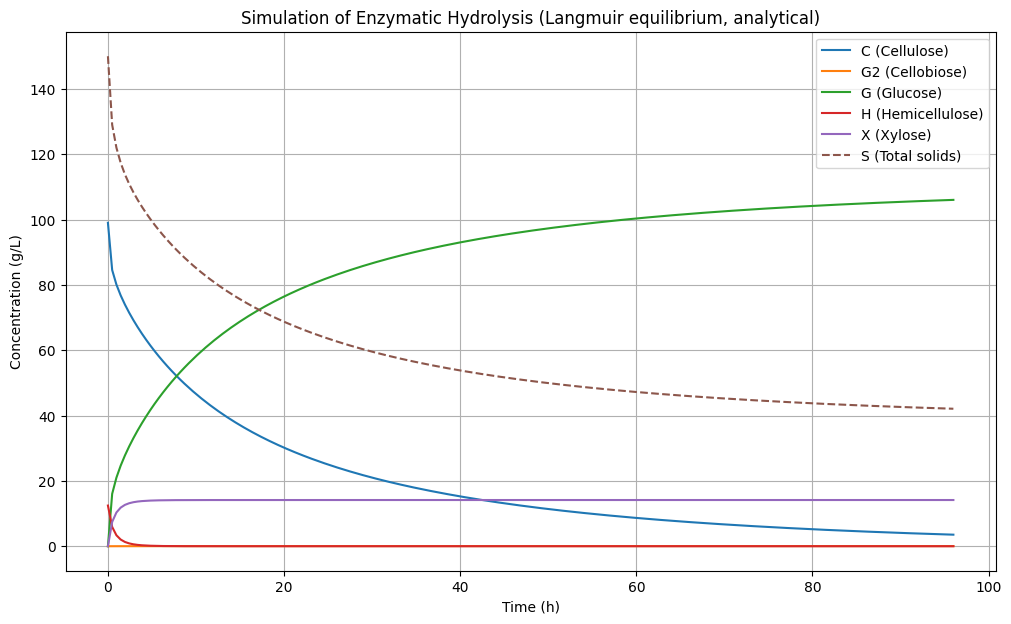

In [43]:
# Célula 28 - Modelo com equilíbrio instantâneo de adsorção (isoterma de Langmuir, solução analítica)

import numpy as np
from scipy.integrate import solve_ivp

# Defina a composição da biomassa e a carga de sólidos (exemplo)
biomass_composition = {
    'cellulose': 0.66,
    'hemicellulose': 0.083,
    'lignin': 0.257
}
solids_loading_g_L = 150 # concentração total de sólidos em g/L

# Calculando as concentrações iniciais
C0 = solids_loading_g_L * biomass_composition['cellulose']
H0 = solids_loading_g_L * biomass_composition['hemicellulose']
L0 = solids_loading_g_L * biomass_composition['lignin']

S0 = C0 + H0 + L0

params = {
    "alpha": 1,
    "Emax": 8.32,
    "Kad": 7.16,
    "k1r": 0.509,
    "k2r": 12.75,
    "k3r": 165.7,
    "k4r": 13.46,
    "K1iG": 0.016,
    "K1iG2": 0.710,
    "K1iX": 0.559,
    "K2iG": 89.18,
    "K2iG2": 0.551,
    "K2iX": 0.581,
    "K3M": 47.20,
    "K3iG": 0.011,
    "K3iX": 110.0,
    "K4iG": 30.16,
    "K4iG2": 8.61,
    "K4iX": 134.1
}

Et = 0.176  # g/L

def solve_Ef_analytical(S, Emax, Kad, Et):
    # Resolve a equação quadrática para Ef:
    # (Kad*S*Emax)*Ef^2 + (1 + Kad*S*Emax - Kad*Et*S)*Ef - Et = 0
    # Mas a equação correta é:
    # Et = Ef + S*Emax*Kad*Ef/(1+Kad*Ef)
    # Rearranjando:
    # Et*(1+Kad*Ef) = Ef*(1+Kad*Ef) + S*Emax*Kad*Ef
    # Et + Et*Kad*Ef = Ef + Kad*Ef**2 + S*Emax*Kad*Ef
    # 0 = Kad*Ef**2 + (1 + S*Emax*Kad - Et*Kad)*Ef - Et
    a = Kad
    b = 1 + S*Emax*Kad - Et*Kad
    c = -Et
    delta = b**2 - 4*a*c
    if delta < 0:
        return max(Et, 0)  # fallback
    Ef1 = (-b + np.sqrt(delta)) / (2*a)
    Ef2 = (-b - np.sqrt(delta)) / (2*a)
    # Ef deve ser positivo e menor que Et
    Ef = Ef1 if 0 <= Ef1 <= Et else Ef2
    if Ef < 0 or Ef > Et:
        Ef = max(0, min(Ef1, Ef2, Et))
    return Ef

def hydrolysis_ode(t, y, params, S0=S0, Et=Et):
    C, G2, G, H, X = y

    alpha = params["alpha"]
    Emax = params["Emax"]
    Kad = params["Kad"]
    k1r = params["k1r"]
    k2r = params["k2r"]
    k3r = params["k3r"]
    k4r = params["k4r"]
    K1iG = params["K1iG"]
    K1iG2 = params["K1iG2"]
    K1iX = params["K1iX"]
    K2iG = params["K2iG"]
    K2iG2 = params["K2iG2"]
    K2iX = params["K2iX"]
    K3M = params["K3M"]
    K3iG = params["K3iG"]
    K3iX = params["K3iX"]
    K4iG = params["K4iG"]
    K4iG2 = params["K4iG2"]
    K4iX = params["K4iX"]

    S = C + H + L0
    Rs = alpha * S / S0

    # Solução analítica para Ef
    Ef = solve_Ef_analytical(S, Emax, Kad, Et)
    Eb = Et - Ef

    Ebc = Eb * C / S if S > 0 else 0
    Ebh = Eb * H / S if S > 0 else 0

    r1 = k1r * Ebc * S * Rs / (1 + G2 / K1iG2 + G / K1iG + X / K1iX)
    r2 = k2r * Ebc * S * Rs / (1 + G2 / K2iG2 + G / K2iG + X / K2iX)
    r3 = k3r * Ef * G2 / (((1 + G / K3iG + X / K3iX) * K3M) + G2)
    r4 = k4r * Ebh * Rs * S / (1 + G2 / K4iG2 + G / K4iG + X / K4iX)

    dC_dt = -r1 - r2
    dG2_dt = 1.056 * r1 - r3
    dG_dt = 1.111 * r2 + 1.053 * r3
    dH_dt = -r4
    dX_dt = 1.136 * r4

    return [dC_dt, dG2_dt, dG_dt, dH_dt, dX_dt]

y0 = [C0, 0, 0, H0, 0]

t_span = (0, 96)
t_eval = np.linspace(t_span[0], t_span[1], 200)

solution = solve_ivp(
    hydrolysis_ode, t_span, y0, args=(params, S0, Et), t_eval=t_eval
)

C = solution.y[0]
H = solution.y[3]
L = L0
S_t = C + H + L

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))
plt.plot(solution.t, C, label="C (Cellulose)")
plt.plot(solution.t, solution.y[1], label="G2 (Cellobiose)")
plt.plot(solution.t, solution.y[2], label="G (Glucose)")
plt.plot(solution.t, H, label="H (Hemicellulose)")
plt.plot(solution.t, solution.y[4], label="X (Xylose)")
plt.plot(solution.t, S_t, '--', label="S (Total solids)")
plt.xlabel("Time (h)")
plt.ylabel("Concentration (g/L)")
plt.legend()
plt.title("Simulation of Enzymatic Hydrolysis (Langmuir equilibrium, analytical)")
plt.grid()
plt.show()

In [44]:
# Adicionar as unidades (g/L) aos nomes das colunas de concentração ao criar o DataFrame
import pandas as pd
def generate_dataframe(solution):
    data = {
        "Time (h)": solution.t,
        "Cellulose (C) [g/L]": solution.y[0],
        "Cellobiose (G2) [g/L]": solution.y[1],
        "Glucose (G) [g/L]": solution.y[2],
        "Hemicellulose (H) [g/L]": solution.y[3],
        "Xylose (X) [g/L]": solution.y[4]
    }
    df = pd.DataFrame(data)
    return df

# Criar o dataframe
df_simulation = generate_dataframe(solution)

# Baixar o dataframe como CSV
# df_simulation.to_csv("enzymatic_hydrolysis_simulation.csv", index=False)

# Exibir os pontos
df_simulation

,Time (h),Cellulose (C) [g/L],Cellobiose (G2) [g/L],Glucose (G) [g/L],Hemicellulose (H) [g/L],Xylose (X) [g/L]
0,0.000000,99.000000,0.000000,0.000000,1.245000e+01,0.000000
1,0.482412,84.547921,0.009254,16.046524,5.900253e+00,7.440512
2,0.964824,80.091158,0.011915,20.995188,3.351835e+00,10.335515
3,1.447236,76.783416,0.013884,24.668018,2.046661e+00,11.818193
4,1.929648,73.982132,0.015478,27.778566,1.307812e+00,12.657525
...,...,...,...,...,...,...
195,94.070352,3.700688,0.036158,105.839494,1.775687e-07,14.143200
196,94.552764,3.658544,0.036165,105.886309,1.821463e-07,14.143200
197,95.035176,3.616919,0.036172,105.932546,1.827559e-07,14.143200
198,95.517588,3.575806,0.036179,105.978216,1.788417e-07,14.143200
